In [1]:
import pandas as pd
from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from openTSNE import TSNE

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

In [2]:
meth_dict = {
 'data analysis / statistical analysis / econometrics' : 'Data Analysis / Statistical Analysis / Econometrics',
 'experimental - field /fieldstudy': 'Experimental - Field Study',
 'experimental - laboratory': 'Experimental - Laboratory',
 'modelling': 'Modelling',
 'qualitative research': 'Qualitative Research',
 'review': 'Review',
 'survey': 'Survey',
 'systematic reviews': 'Systematic Review',
 'Unknown Method': 'Unknown Method',
 'Life Cycle Assessments': 'Life Cycle Assessment'
 }
exp = ['experimental - field /fieldstudy',
 'experimental - laboratory']
modelling = ['modelling','data analysis / statistical analysis / econometrics','Life Cycle Assessments']
qualit = ['review','systematic reviews','survey','qualitative research']
unknown = ['Unknown Method']

col_exp = ['#a6bddb','#1c9099'] # green-blue
col_model = ['#fdbe85','#fd8d3c','#d94701'] # oranges
col_qual = ['#feebe2','#fbb4b9','#f768a1','#ae017e'] # pinks
col_unk = ['#cccccc']

col_meths = col_exp + col_model + col_qual + col_unk
meth_goodOrder = exp + modelling + qualit + unknown

mc = {}
for idx, m in enumerate(meth_goodOrder):
    mc[m] = col_meths[idx]

In [3]:
df = pd.read_csv("../data/daccs_wTopicDescriptions.csv")
meths = pd.read_csv("../data/2023-06-18_meth_predicted_unbalanced_hyperparamTuning.csv", 
                    converters={"all_pred_meth": literal_eval})
meths_ex = meths.explode("all_pred_meth")
meths_ex = meths_ex.loc[meths_ex.all_pred_meth!="statistical analysis / econometrics"]
meths = meths_ex.groupby("id", as_index=False)["all_pred_meth"].first()
df = df.merge(meths[["id","all_pred_meth"]], on="id", how="left")
df["col"] = df["all_pred_meth"].replace(mc)

In [4]:
vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_text = vectorizer.fit_transform(df["title_abstract"])

In [13]:
pca = TruncatedSVD(n_components=50)
pca_result = pca.fit_transform(tfidf_text)
tsne = TSNE(
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=42,
    verbose=True,
    dof=0.8,
    n_iter=1000
)
tsne_fit = tsne.fit(pca_result)

df["tsne_x"] = list(tsne_fit[:,0])
df["tsne_y"] = list(tsne_fit[:,1])

df.to_csv("../data/topics_tsne.csv", index=False)

--------------------------------------------------------------------------------
TSNE(dof=0.8, early_exaggeration=12, metric='cosine', n_iter=1000, n_jobs=8,
     random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.13 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=68.25 for 250 iterations...
Iteration   50, KL divergence 3.2040, 50 iterations in 0.2230 sec
Iteration  100, KL divergence 3.2122, 50 iterations in 0.0581 sec
Iteration  150, KL divergence 3.1980, 50 iterations in 0.2132 sec
Iteration  200, KL divergence 3.1969, 50 iterations in 0.1976 sec
Iteration  250, KL divergence 3.1981, 50 iterations in 0.1560 sec
   --> Time elapsed: 0.85 seconds
===> Running optim

In [14]:
df["col"].value_counts()

col
#1c9099    379
#feebe2    194
#fdbe85    146
#fd8d3c     46
#d94701     18
#cccccc     17
#ae017e      7
#f768a1      4
#fbb4b9      2
#a6bddb      2
Name: count, dtype: int64

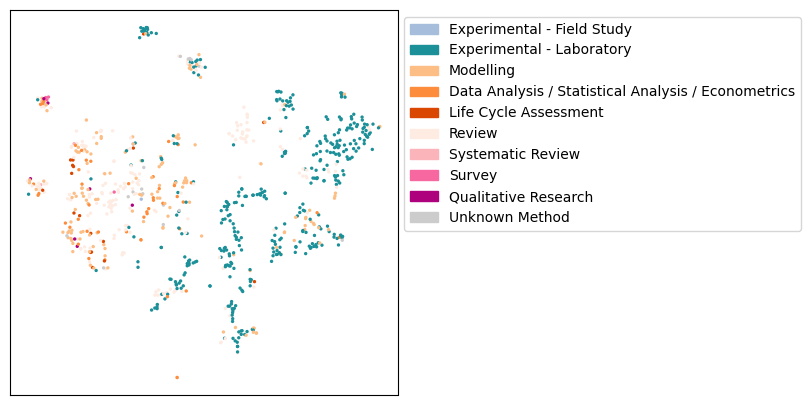

In [15]:
## complete with predicted tech
fig, ax = plt.subplots(figsize=(5,5))

plot_df = df.dropna(subset=["col"])

#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

_ = ax.scatter(plot_df.tsne_x, plot_df.tsne_y, s=2, c=plot_df["col"])

legend_labels = []
for m in meth_goodOrder:
    legend_labels.append(mpatches.Patch(color=mc[m], label=meth_dict[m]))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1), fontsize=10)
fig.savefig("../figures/beccs_map_techs.png", bbox_inches="tight", facecolor='white', edgecolor='none')

In [16]:
import matplotlib.patches as mpatches
import numpy as np

### TFIDF

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(df[["tsne_x","tsne_y"]])
classes = np.unique(kmeans.labels_)


/home/tim/workspace/ecosystem/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
cluster_titles = ['' for _ in classes]
for li, ll in enumerate(kmeans.labels_):
    tit = df.iloc[li]['title']
    if tit is not None:
        cluster_titles[ll] += tit

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), min_df=1, max_df=0.6, strip_accents='ascii')
vectors = vectorizer.fit_transform(cluster_titles)
iv = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_keywords = [
    iv[kwi[0]]
    for kwi in vectors.argmax(axis=1).tolist()
]

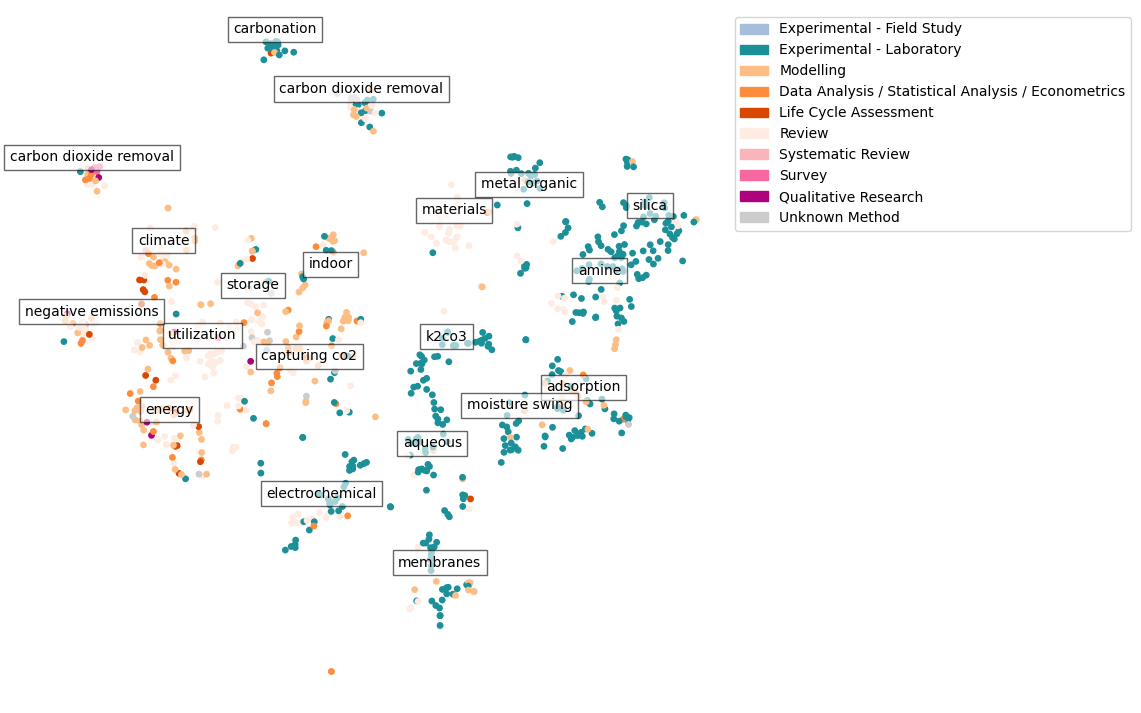

In [20]:
import matplotlib
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(9,9))
#scatter = ax.scatter(df.tsne_x, df.tsne_y, s=0.2, c=df.tech_color)

plot_df = df.dropna(subset=["col"])
sizemap = {0: 1, 1: 10, 2: 10, 3: 20}
_ = ax.scatter(plot_df.tsne_x, plot_df.tsne_y, s=15, c=plot_df.col, rasterized=True)

# Draw cluster labels
for idx, label in enumerate(cluster_keywords):
    ax.text(
        kmeans.cluster_centers_[idx, 0],
        kmeans.cluster_centers_[idx, 1] + 2.2,
        label,
        fontsize=10,
        horizontalalignment="center",
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )

# Hide ticks and axis
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# legend
legend_labels = []
for m in meth_goodOrder:
    legend_labels.append(mpatches.Patch(color=mc[m], label=meth_dict[m]))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))
fig.savefig('../figures/beccs_map_tfidf_20cluster.png', bbox_inches="tight", facecolor='white', edgecolor='none')